In [11]:
import numpy as np
import gym
from gym import spaces
import torch
import torch.nn as nn
import torch.optim as optim
from collections import deque
import random
import matplotlib.pyplot as plt
from IPython.display import display, clear_output

KeyboardInterrupt: 

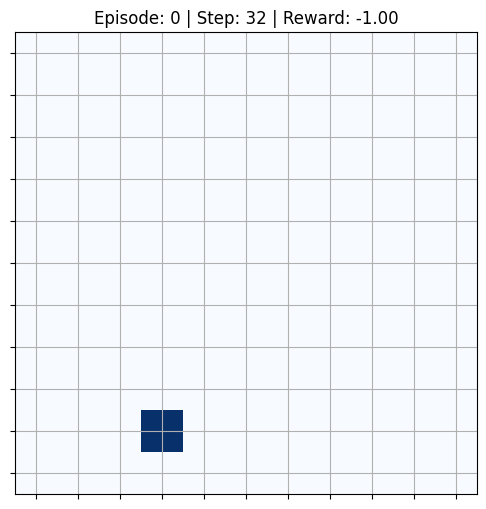

In [ ]:

class StayStillEnv(gym.Env):
    def __init__(self):
        super(StayStillEnv, self).__init__()
        self.grid_size = 11
        self.action_space = spaces.Discrete(5)  # [stay, up, down, left, right]
        self.observation_space = spaces.Box(low=0, high=10, shape=(2,), dtype=np.int32)
        self.reset()
        
        # UI Setup
        self.fig, self.ax = plt.subplots(figsize=(6, 6))
        self.img = None
        self.grid = np.zeros((self.grid_size, self.grid_size))
        self.ax.set_xticks(np.arange(self.grid_size))
        self.ax.set_yticks(np.arange(self.grid_size))
        self.ax.set_xticklabels([])
        self.ax.set_yticklabels([])
        self.ax.grid(True)

    def reset(self):
        self.agent_pos = np.array([5, 5])  # start at center
        self.steps = 0
        self.episode_count = 0
        self.reward = 0
        self.done = False
        return self.agent_pos

    def step(self, action):
        x, y = self.agent_pos

        # Move based on action
        if action == 1 and y > 0:      # up
            y -= 1
        elif action == 2 and y < 10:   # down
            y += 1
        elif action == 3 and x > 0:    # left
            x -= 1
        elif action == 4 and x < 10:   # right
            x += 1
        # action == 0 means stay still

        self.agent_pos = np.array([x, y])
        reward = self.calculate_reward(action)

        self.steps += 1
        self.reward = reward
        
        if self.steps >= 50:  # Maximum number of steps in each episode
            self.done = True
        return self.agent_pos, reward, self.done, {}

    def calculate_reward(self, action):
        x, y = self.agent_pos
        # Preferred zone: center 3x3
        if 4 <= x <= 6 and 4 <= y <= 6:
            if action == 0:
                return 1.0  # reward for staying still
            else:
                return -0.1  # small penalty for moving

        # Medium penalty zone: between outer and inner square
        elif 2 <= x <= 9 and 2 <= y <= 9:
            return -1.0

        # Outside penalty zone
        else:
            return -10.0

    def render(self):
        self.grid = np.zeros((self.grid_size, self.grid_size))
        x, y = self.agent_pos
        self.grid[y, x] = 1  # Mark the agent's position
        
        # Plot the grid
        if self.img is None:
            self.img = self.ax.imshow(self.grid, cmap='Blues', interpolation='nearest', vmin=0, vmax=1)
        else:
            self.img.set_data(self.grid)

        # Display additional information
        self.ax.set_title(f'Episode: {self.episode_count} | Step: {self.steps} | Reward: {self.reward:.2f}')
        
        # Use IPython display for real-time updates
        clear_output(wait=True)
        display(self.fig)
        
    def close(self):
        plt.show()


# Define the Q-Network (Deep Q-Network)
class QNetwork(nn.Module):
    def __init__(self, input_size, output_size):
        super(QNetwork, self).__init__()
        self.fc1 = nn.Linear(input_size, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, output_size)
    
    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        return self.fc3(x)

class DQNAgent:
    def __init__(self, env, device):
        self.env = env
        self.device = device
        self.action_space = env.action_space
        self.state_space = env.observation_space
        self.memory = deque(maxlen=2000)  # Experience replay
        self.batch_size = 64
        self.gamma = 0.99  # Discount factor
        self.epsilon = 1.0  # Exploration rate
        self.epsilon_min = 0.01
        self.epsilon_decay = 0.995
        self.learning_rate = 0.001
        self.target_update_freq = 10

        self.model = QNetwork(2, 5).to(self.device)  # 2 inputs (x, y) and 5 possible actions
        self.target_model = QNetwork(2, 5).to(self.device)
        self.target_model.load_state_dict(self.model.state_dict())
        self.optimizer = optim.Adam(self.model.parameters(), lr=self.learning_rate)
        self.episode_count = 0

    def remember(self, state, action, reward, next_state, done):
        self.memory.append((state, action, reward, next_state, done))

    def act(self, state):
        if np.random.rand() <= self.epsilon:
            return self.action_space.sample()  # Random action (exploration)
        state = torch.tensor(state, dtype=torch.float32).unsqueeze(0).to(self.device)
        q_values = self.model(state)
        return torch.argmax(q_values).item()  # Greedy action (exploitation)

    def replay(self):
        if len(self.memory) < self.batch_size:
            return
        batch = random.sample(self.memory, self.batch_size)
        for state, action, reward, next_state, done in batch:
            state = torch.tensor(state, dtype=torch.float32).unsqueeze(0).to(self.device)
            next_state = torch.tensor(next_state, dtype=torch.float32).unsqueeze(0).to(self.device)

            target = reward
            if not done:
                target = reward + self.gamma * torch.max(self.target_model(next_state)).item()

            q_values = self.model(state)
            q_values[0][action] = target

            self.optimizer.zero_grad()
            loss = torch.nn.functional.mse_loss(q_values, self.model(state))
            loss.backward()
            self.optimizer.step()

        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay

    def update_target_model(self):
        self.target_model.load_state_dict(self.model.state_dict())


# Training Loop
def train_dqn(episodes=1000):
    env = StayStillEnv()
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    agent = DQNAgent(env, device)
    for episode in range(episodes):
        print(f"Episode {episode+1}, Total Reward: {total_reward:.2f}, Epsilon: {agent.epsilon:.2f}")
        state = env.reset()
        total_reward = 0
        done = False
        while not done:
            action = agent.act(state)
            next_state, reward, done, _ = env.step(action)
            agent.remember(state, action, reward, next_state, done)
            agent.replay()
            state = next_state
            total_reward += reward
            env.render()  # Render after each step to update the UI
        agent.update_target_model()
        agent.episode_count = agent.episode_count + 1
        print(f"Episode {episode+1}, Total Reward: {total_reward:.2f}, Epsilon: {agent.epsilon:.2f}")
    env.close()

# Start training the DQN agent
train_dqn(episodes=100)


NameError: name 'agent' is not defined